In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision as tv

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt

Let's implement the concepts from the video in torch. First, we need an image to work with. This image of a chess board was deliberately chosen because it contains many vertical and horizontal edges to detect.

In the cell block below, we load the image into memory and convert it to a greyscale image.

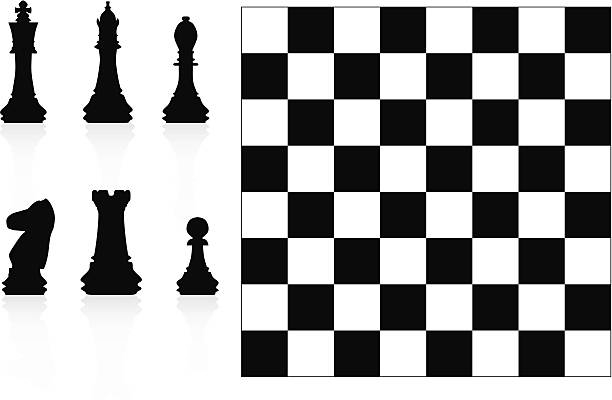

In [ ]:
url = 'https://media.istockphoto.com/vectors/chess-silhouettes-vector-id165635822?b=1&k=20&m=165635822&s=612x612&w=0&h=pmf6FVa--nzyWCKb0SyTkIi3xdaHaamJuaR-FIjw1iI='
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')
img

In the code block below, we define two operations using torchvision.transforms. The first takes a PIL.Image object and converts it to a tensor, and the second takes a tensor and converts it to a PIL.Image object. We'll go over more advanced usage of transforms later in the course, but for now we'll just use these two transforms.

In [ ]:
to_tensor = tv.transforms.ToTensor()
to_image = tv.transforms.ToPILImage()

Since it's a greyscale image, there's only 1 channel. Later on, we'll be using F.conv2d to apply a filter (a.k.a. kernel) to our image, which expects a batch of images, so we use .unsqueeze(0) to add a batch dimension. So in the end, we have a batch of 1 1-channel image.

In [ ]:
img_tensor = (
    to_tensor(img) # Convert to tensor
    .unsqueeze(0) # Add a batch dimension
    / 255. # Scale between 0 and 1.
)
img_tensor.shape

torch.Size([1, 1, 400, 612])

https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch

Next, let's create our filter. This filter will create large values when there are large values on the left and smaller values on the right of some column of pixels. In other words, any pixel that's dark on the left and light on the right should output a high value.

F.conv2d is built to apply more than one filter at a time. It expects filters to be have the dimensions (out_channels, in_channels, filter_height, filter_width). Since we have only 1 input channel and only want 1 output channel, we add a few empty dimensions to the filter so it will work with F.conv2d.

In [ ]:
vertical_filter = torch.tensor([
    [1., 0, -1],
    [1., 0, -1],
    [1., 0, -1],
]).unsqueeze(0).unsqueeze(0)

Finally, let's apply our filter over the image using F.conv2d. We also use our to_image transform to convert it back to a PIL.Image for easy viewing.

In [ ]:
vert_output = F.conv2d(img_tensor, vertical_filter).squeeze()
vert_image = to_image(vert_output)

Finally, let's compare the input (the original image) and the output, also called a feature map. By comparing the two images, can you conceptualize why each white region in the feature map was activated?

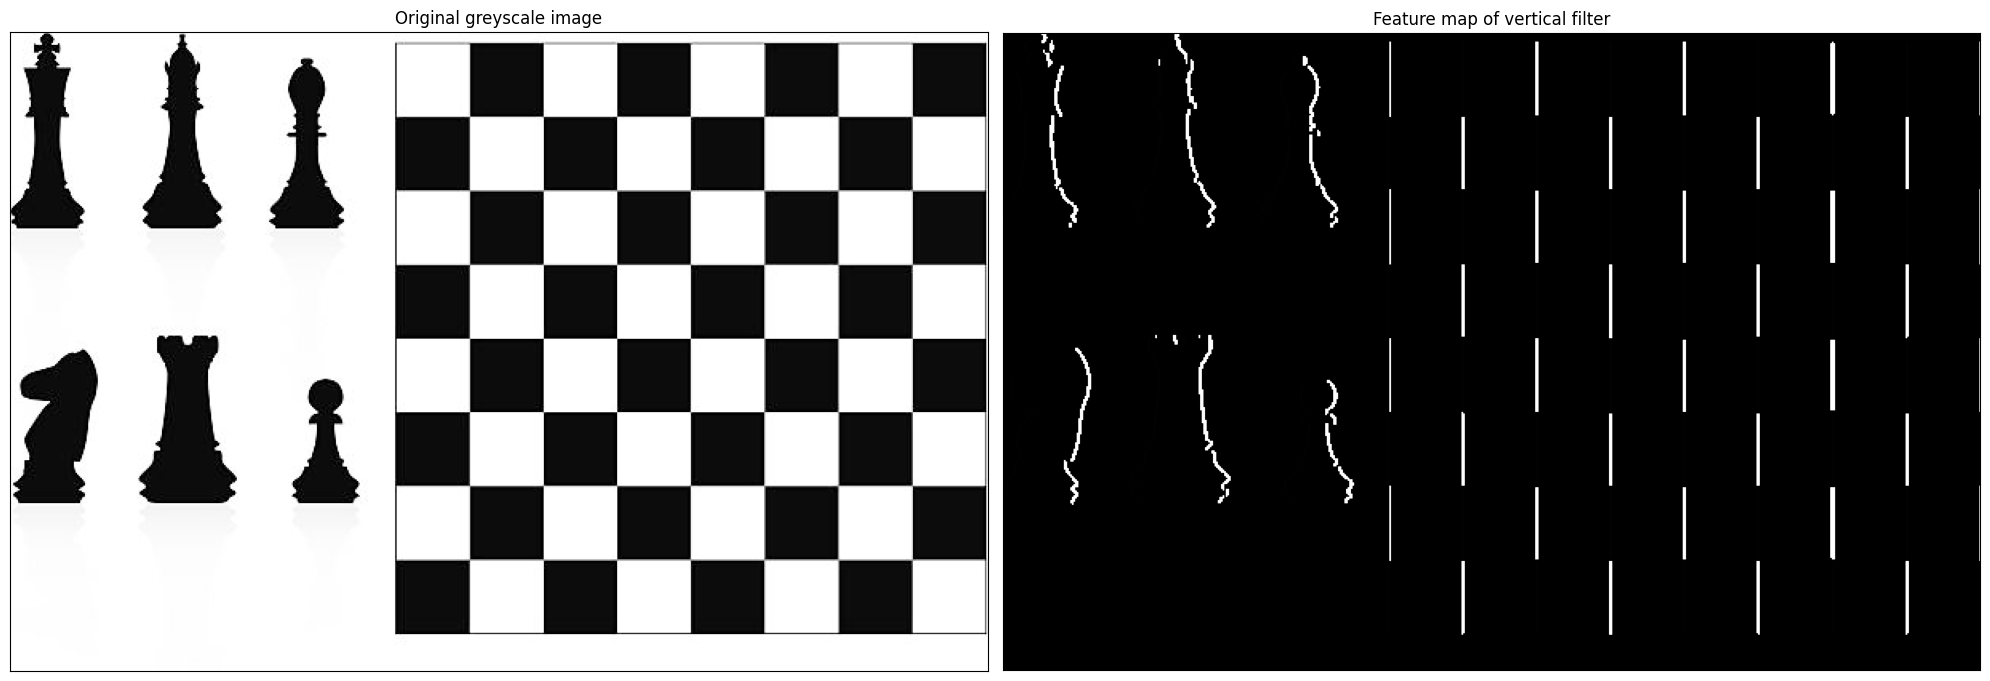

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img, cmap='Greys_r')
axes[0].set_title('Original greyscale image')
axes[1].imshow(vert_image, cmap='Greys_r')
axes[1].set_title('Feature map of vertical filter')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

# Exercise 10.1

Use what you learned in this lesson to create a horizontal feature map.
The result of this exercise should be an edge detector that detects the top edges of the chess pieces and squares on the board.

Then, use the `F.conv2d` to apply the filter.

<!-- startquestion -->

In [ ]:
# Your code here
horizontal_filter = torch.tensor([
    [1., 1., 1.],
    [0, 0, 0],
    [-1, -1, -1],
]).unsqueeze(0).unsqueeze(0)

horizontal_tensor = F.conv2d(img_tensor, horizontal_filter).squeeze()
horizontal_image = to_image(horizontal_tensor)

In [ ]:
assert horizontal_filter.ndim == 4

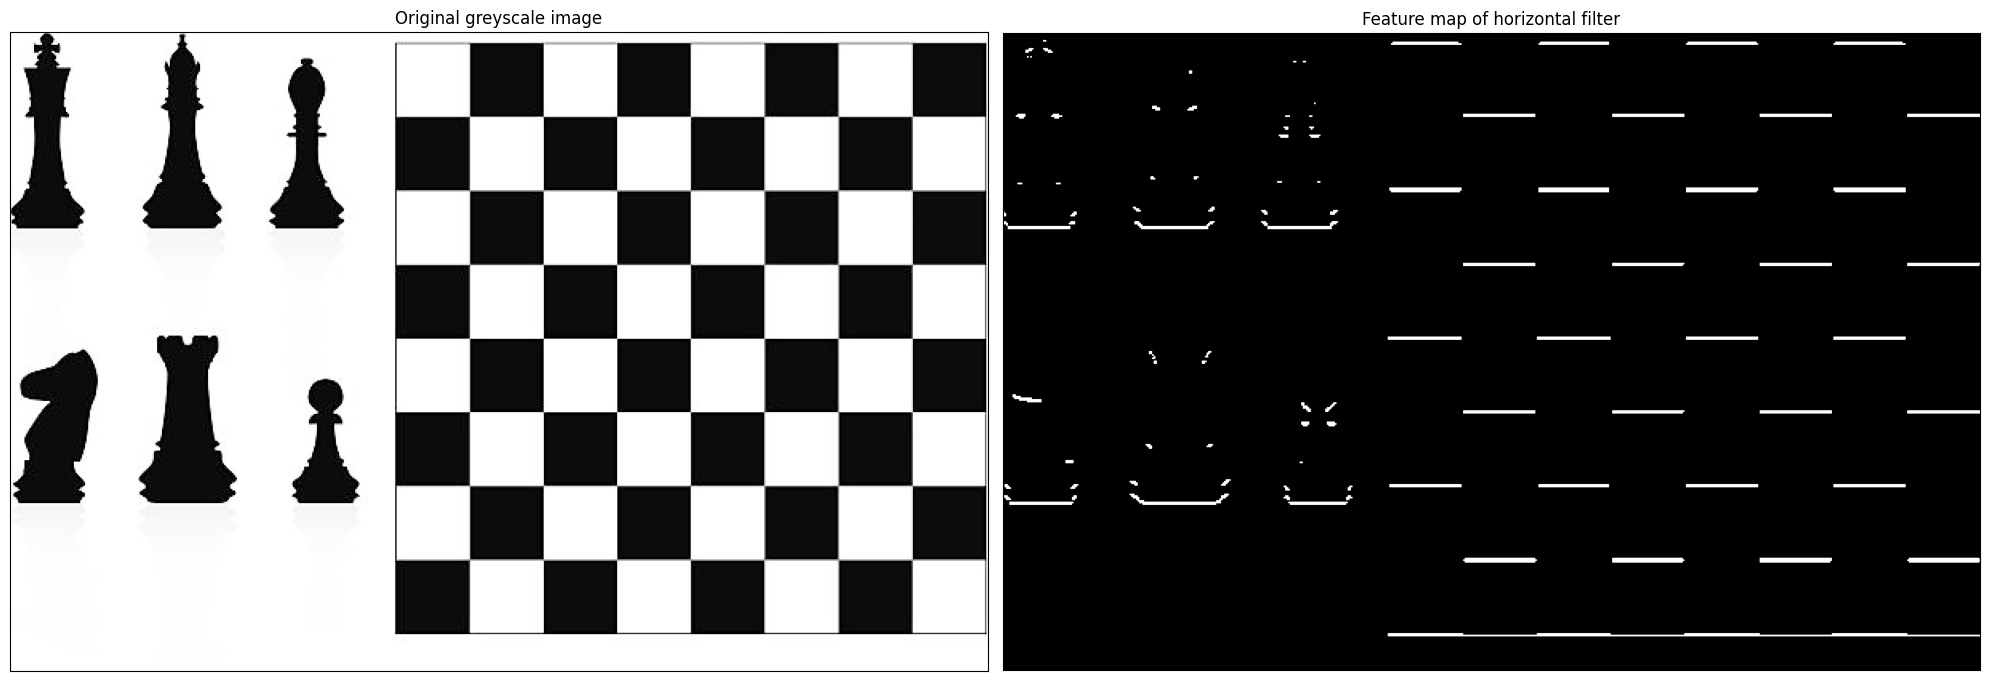

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img, cmap='Greys_r')
axes[0].set_title('Original greyscale image')
axes[1].imshow(horizontal_image, cmap='Greys_r')
axes[1].set_title('Feature map of horizontal filter')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

In practice, we will want to apply more than one filter at the same time. To finish out this lesson, we will combine our two filters and obtain feature maps for both of them at the same time.

First, let's use torch.cat to combine our filters. Remember, F.conv2d expects our filters to be in the shape of (out_channels, in_channels, filter_height, filter_width). In this case, we will have 1 input channel and 2 output channels, so we will concatenate these tensors along the 0th dimension.

In [ ]:
two_filters = torch.cat([vertical_filter, horizontal_filter], dim=0)
two_filters.shape

torch.Size([2, 1, 3, 3])

https://towardsdatascience.com/understanding-dimensions-in-pytorch-6edf9972d3be

Next, let's apply our convolution.

In [ ]:
two_filter_output = F.conv2d(img_tensor, two_filters)
two_filter_output.shape

torch.Size([1, 2, 398, 610])

Our output here is the outputs of each individual filter appied to the image stacked on top of each other. In the cell below, we split the outputs and turn them into images.

In [ ]:
# unpack the filters into their own tensors
vert_output, horizontal_output = two_filter_output.squeeze()
# convert tensors to images
vert_image = to_image(vert_output.squeeze())
horizontal_image = to_image(horizontal_output.squeeze())

Finally, let's plot our outputs to see our results. We can see they're the same as the results from applying the same filters individualy.

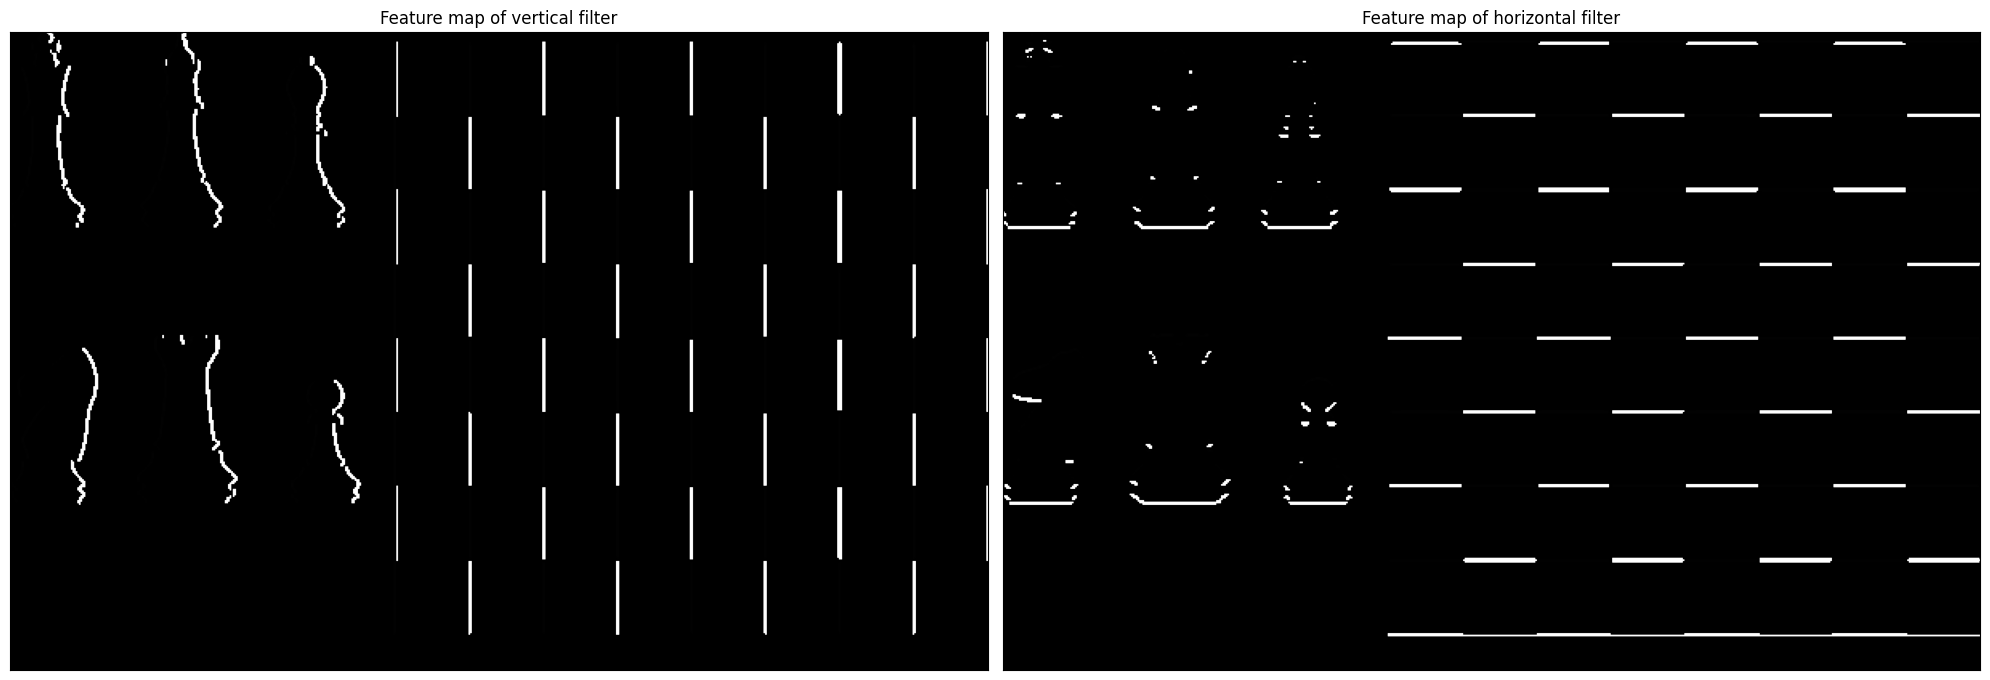

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(vert_image, cmap='Greys_r')
axes[0].set_title('Feature map of vertical filter')
axes[1].imshow(horizontal_image, cmap='Greys_r')
axes[1].set_title('Feature map of horizontal filter')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

Padding

You may have noticed that our image actually shrunk a bit when we applied our convolutional filters. This is because there are fewer possible 3x3 regions in the original image than there are pixels in the original image. When you have many convolutional operations stacked in a deep CNN, this can make keeping track of the shapes in each layer tedious.

To address this, we use a technique called padding. You add some values to the edge of the image so that the height and width of the output are the same as those of the input.

What does padding look like? Commonly, inputs are padded with 0 values (called zero-padding). There are other methods, including reflective padding, where the values are filled with a reflection of the values on the edges of the image.

The cell blocks below illustrate the results of two types of padding. Normally, only one border of values are added, but in the example below we added a large border so the padding would be visible in images.

Padding can be passed as part of F.conv2d, but there are also separate padding layers shown below. Here, we instantiate two types of padding:

Zero padding: add a border of zeros
Reflective padding: Reflect the values in the image to populate the border

In [ ]:
zero_pad = nn.ZeroPad2d(30)
reflection_pad = nn.ReflectionPad2d(30)

Below, we see the image result of padding the original image with zeros.

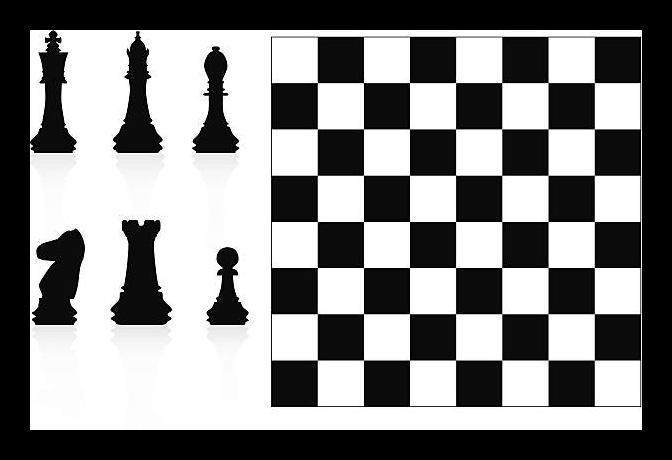

In [ ]:
to_image(zero_pad(img_tensor).squeeze() * 255)

Below, we see the result of padding the original image using reflective padding.

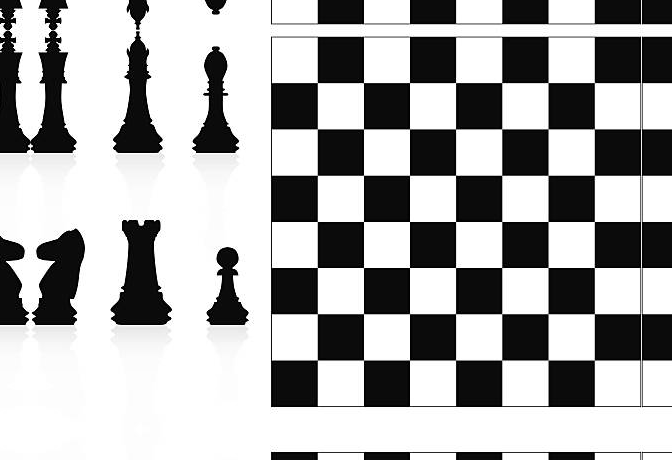

In [ ]:
to_image(reflection_pad(img_tensor).squeeze() * 255)

When we train CNNs, we will use the nn.Conv2d layer, wh. This layer has arguments for padding and pading mode. One easy way to do this is to pass padding='same' to F.conv2d or nn.Conv2d.

To finish this lesson, let's perform a final sanity check to see that padding keeps the image width and height constanct. Here are the checks we're performing:

The original shape is the same as the feature map with padding='same'
The original shape is the same as the feature map with padding=1
The original shape is not the same as the feature map without padding

In [ ]:
assert img_tensor.shape == F.conv2d(img_tensor, vertical_filter, padding='same').shape
assert img_tensor.shape == F.conv2d(img_tensor, vertical_filter, padding=1).shape
assert not img_tensor.shape == F.conv2d(img_tensor, vertical_filter).shape

Strided Convolutions

As we build deep convolutional networks, we'll see that the layers closest to the input contain a lot of spatial information. However, as we get closer to a classification head, we care much less about spatial information. Throughout most CNN architechtures, the spatial resolution (width and height) of the features are reduced at one or more points in the CNN. One way to do that is with striding.

Up until now, when we perform convolutions we move our filters one pixel to generate a new value for our output. However, we can move our filters by more than one pixel. The number of pixels we move is a hyperparameter called stride that helps reduce the spatial dimensionality of our features.

The video below explains stride and how it affects the output shape of our features.

Let's take a look at how striding works in practice. By default, convolutions have a stride of 1. In the cells below, we examine the shape of the img_tensor, and the shape of the vertical_filter applied to our original image with a padding of 1 and a stride of 1. We see that the shapes are the same.

In [ ]:
img_tensor.shape

torch.Size([1, 1, 400, 612])

In [ ]:
F.conv2d(img_tensor, vertical_filter, padding=1, stride=1).shape

torch.Size([1, 1, 400, 612])

Now, let's apply a stride of 2 to the same operation. We can see that the height and width of the output are half of that of the original image.

In [ ]:
F.conv2d(img_tensor, vertical_filter, padding=1, stride=2).shape

torch.Size([1, 1, 200, 306])

Convolutions with multi-channel inputs

So far, we've been working with 1-channel images to understand how convolutions work. While this is a great learning technique, it often doesn't represent the data and models we work with in real life. Most images are 3-channels (red, green, blue - RGB). As we pass images through CNNs, we generally expand the number of channels, each representing more complex features. For example, the first layer might have filters that represent edges at different orientations. Other layers may represent textures, more complex visual features like circles or corners, etc. The convolutional filters closest to the output represent high-level features - for example, in a pet classifier, one feature map may be activated by a cat's nose and another by a dog's nose.

This means that we need to be able to perform convolutions on an arbitrary number of channels. In this lesson, we'll dive into multi-channel filters.

Here are some guidelines for understanding multi-channel filters:

Each filter must have the same number of channels as the input. If your input is a 3-channel image, each filter will have 3 channels. If your input is the output of another convolution and has 256 channels, each filter will also have 256 channels.
The number of filters will determine the number of outputs of the convolution, regardless of the input dimensionality. For example, if you have 16 filters, the output will be (batch_size * 16 * height * width), whether the number of input channels is 3 or 1000.
The video below explains multi-channel convolutions in detail.

Because we're now working with multi-channel inputs, let's now work with a color image. We'll work with this image to create filters that expand the number of channelsn the feature map.

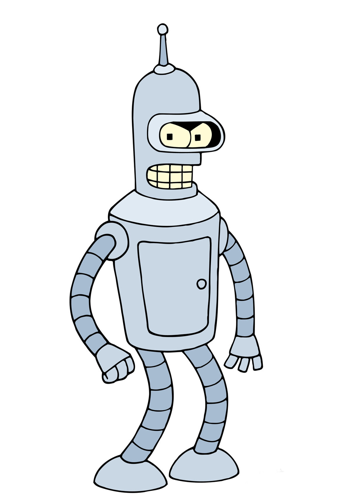

In [ ]:
url = 'https://www.syfy.com/sites/syfy/files/styles/scale--1200/public/cast_futurama_bender_0.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content)).resize((350, 500))
img

In the cell below, the image is converted into a batch of one image.

In [ ]:
img_tensor = to_tensor(img).unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 500, 350])

# Exercise 10.2

Instead of explicitly defining filters, we'll just use random numbers this time.
Based on the `F.conv2d` documentation, the filters should be of shape `(out_channels, in_channels, kernel/filter_height, kernel/filter_width)`.

Complete the code in the cell below to create a filter with a 3x3 kernel that takes in a 3-channel image and returns a 16-channel feature map.
We will use `F.conv2d` to generate the feature map.

<!-- startquestion -->

In [ ]:
out_channels = 16
in_channels = 3
kH = 3
kW = 3
try:
    random_filters = torch.rand((out_channels, in_channels, kH, kW))
    print(random_filters.shape)
except:
    print('Please assign out_channels, in_channels, kH, and kW.')

torch.Size([16, 3, 3, 3])


In [ ]:
outputs = F.conv2d(img_tensor, random_filters, padding=1, stride=1)

In [ ]:
assert outputs.shape[1] == 16

The Conv2d Layer

So far, we've been using the F.conv2d function to apply filters to images. In practice, we will use the nn.Conv2d layer. Conceptually, this layer performs the operations we've gone over so far, with a slight tweak. Each filter has a bias term (just a constant) that's added to that filter that's learned during training.

We'll get plenty of practice using this layer, but for now let's just check that it's doing the same thing as F.conv2d. We'll start by instantiang a nn.Conv2d layer.

First, let's create a convolution layer using nn.Conv2d. We'll pack some of the arguments in a dictionary so we can pass the exact same arts to F.conv2d. In the cell below, we create a convolutional layer where:

in_channels = 3
out_channels = 16
kernel_size (a.k.a. filter size) = 3
padding = 1
stride = 1

In [ ]:
conv_kwargs = {
    'padding': 1,
    'stride': 1
}

conv_layer = nn.Conv2d(3, 16, 3, **conv_kwargs)

Now let's pass our img_tensor through the conv_layer to examine the output.

In [ ]:
conv_layer_output = conv_layer(img_tensor)
conv_layer_output.shape

torch.Size([1, 16, 500, 350])

Just as expected, the output is the same height and width as the input since stride and padding are both 1, but with more channels (3 ➡ 16) since out_channels = 16.

Next, to show that this is doing the same thing as F.conv2d, let's pass the weights and bias tensors from our conv_layer through F.conv2d to make sure it gives us the same outputs as conv_layer.

In [ ]:
conv_function_output = F.conv2d(img_tensor, conv_layer.weight.data, conv_layer.bias.data, **conv_kwargs)

The check below confirms that these two operations are doing the same thing. The main difference is that with nn.Conv2d, you no longer have to create a tensor of filters or a bias tensor, since those come pre-packaged with the convolutional layer.

In [ ]:
assert (conv_function_output == conv_layer_output).all()

Pooling

In this section, we will pooling. The first two types of pooling we'll look at are max and average pooling. These techniques are used to reduce the height and width of feature maps in CNNs. They operate similarly to convolutions, but there are no parameters. Instead of a matrix multiplication, they just take the max (in max pooling) and average (in average pooling) of each window. They also have the same hyperparameters as nn.Conv2d - padding and stride.

For an introduction to padding, please watch the video below.



Now that we've reviewed what pooling is, let's explore the pooling layers in torch. We instantiate them in the cell below.

In [ ]:
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

Now let's apply them to our images and observe how it affects the shape.

In [ ]:
print(f"""
Oringinal image shape: {img_tensor.shape}
Max pool tensor shape: {maxpool(img_tensor).shape}
Avg pool tensor shape: {avgpool(img_tensor).shape}
""")


Oringinal image shape: torch.Size([1, 3, 500, 350])
Max pool tensor shape: torch.Size([1, 3, 250, 175])
Avg pool tensor shape: torch.Size([1, 3, 250, 175])



While it has been used widely as a part of many CNN architectures, many modern architectures achieve similar effects with the stride parameter of convolutional layers. Let's compare the output shape of a convolutional layer with a stride of 2 to a convolutional layer followed by a pooling layer.

First, let's instantiate the two networks.

In [ ]:
conv_stride_2 = nn.Conv2d(3, 3, 3, 2, 1)
conv_then_pool = nn.Sequential(
    nn.Conv2d(3, 3, 3, 1, 1),
    nn.MaxPool2d(2, 2)
)

Then, let's take a look at the shape of the outputs. We can see that they're the same shape.

In [ ]:
print(f"""
Shape of conv with a stride of 2: {conv_stride_2(img_tensor).shape}
Shape of conv with a poolling layer: {conv_then_pool(img_tensor).shape}
""")


Shape of conv with a stride of 2: torch.Size([1, 3, 250, 175])
Shape of conv with a poolling layer: torch.Size([1, 3, 250, 175])



There's another type of pooling that's been very useful for image classification. In a CNN, the output of each convolutioanl layer contains feature maps encoding a number of features (channels) over the space of the image (height and width). However, if we're performing image classification, we need to turn all of this information into a vector to feed into a linear classifier. Also, classifiers don't really care about where things are in an image, only what. There's another type of pooling that just gives us the average or max of each filter. This is called adaptive (torch) pooling, also known as global (tensorflow) pooling.

How does this work? If we have a 16-channel feature map, adaptive max pooling will take the max of each channel and return a vector of 16. If we're using adaptive average pooling, we just take the average of each channel instead of the max. Let's examine the usage below.

In [ ]:
adapt_avg_pool = nn.AdaptiveAvgPool2d(1)
adapt_max_pool = nn.AdaptiveMaxPool2d(1)

Let's use our outputs tensor from before. This should have 16 features, height, and width.

In [ ]:
outputs.shape

torch.Size([1, 16, 500, 350])

After passing these outputs through either adaptive average or max pooling, we can see that the height and width are both reduced to 1.

In [ ]:
adapt_avg_pool(outputs).shape

torch.Size([1, 16, 1, 1])

We still need a vector, so we need to get rid of these last two dimensions. We can use .squeeze, or we can use nn.Flatten. See the example below of how to use nn.Flatten. We can now see the output is a tensor of shape (batch_zize, n_features).

In [ ]:
adapt_pool_with_flatten = nn.Sequential(
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten()
)

print(adapt_pool_with_flatten(outputs).shape)

torch.Size([1, 16])
